<a href="https://colab.research.google.com/github/zyduan202/BASF_Project2/blob/main/Code_replication_and_random_seed_effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file adds additional code to calculate the confidence interval for SHAP values and examines the effects of varying random seeds, augmenting the original code provided in the reference paper.

# A. Data preparation

In [ ]:
!pip install shap
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from math import sqrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.9 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
data = pd.read_excel('/content/PNNL_data_FinalCurated.xlsx', sheet_name ='Initial set')

In [ ]:
X = data[["crystal radius",'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp"]]

y = data['F_STY']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

# B. Class and function

## Class for confidence interval

In [ ]:
class SHAPConfidenceAnalyzer:

    def __init__(self, confidence_level, X, model, n_samples=1000):
        self.confidence_level = confidence_level
        self.X = X
        self.n_samples = n_samples
        self.model = model
        self.feature_names = X.columns.tolist()

    def compute_confidence_intervals(self, n_samples=None, random_seed=0):
        """ Compute bootstrap confidence intervals for the absolute mean SHAP values of all features. """

        # If n_samples is not provided, use the default value set during initialization
        n_samples = n_samples or self.n_samples

        # Set the random seed for reproducibility
        np.random.seed(random_seed)

        # Initialize a dictionary to store SHAP values for each feature
        bootstrap_shap_dict = {feature: [] for feature in self.feature_names}

        # Bootstrapping loop
        for _ in range(n_samples):
            # Sample with replacement from X
            sample_indices = np.random.choice(self.X.index, size=len(self.X), replace=True)
            X_sample = self.X.iloc[sample_indices]

            # Compute SHAP values for the bootstrap sample
            explainer = shap.Explainer(self.model)
            shap_values_sample = explainer(X_sample)

            # Get the absolute average SHAP value for each feature in this bootstrap sample
            for feature in self.feature_names:
                avg_shap_value = np.abs(shap_values_sample.values[:, self.feature_names.index(feature)]).mean()
                bootstrap_shap_dict[feature].append(avg_shap_value)

        # Compute mean SHAP value, lower and upper bounds for each feature
        results = []
        for feature, values in bootstrap_shap_dict.items():
            mean_shap_value = np.mean(values)
            lower_bound = np.percentile(values, (1 - self.confidence_level) / 2 * 100)
            upper_bound = np.percentile(values, (1 + self.confidence_level) / 2 * 100)
            interval_length = upper_bound - lower_bound
            results.append([feature, mean_shap_value, lower_bound, upper_bound, interval_length])

        # Convert to a DataFrame and sort by Absolute Mean SHAP in descending order
        df_results = pd.DataFrame(results, columns=['Feature', 'Absolute Mean SHAP', 'Lower Bound', 'Upper Bound', 'Interval Length'])
        df_results = df_results.sort_values(by="Absolute Mean SHAP", ascending=False)

        return df_results

    def plot_confidence_intervals(self, df_results):
        """ Plot the confidence intervals for each feature. """

        df_sorted = df_results.sort_values(by="Absolute Mean SHAP", ascending=True)

        plt.figure(figsize=(12, len(df_sorted["Feature"]) * 0.5))
        plt.errorbar(df_sorted["Absolute Mean SHAP"], df_sorted["Feature"],
                    xerr=(df_sorted["Upper Bound"] - df_sorted["Lower Bound"]) / 2,
                    fmt='o', capsize=5, elinewidth=2)
        plt.xlabel("Absolute Mean SHAP Value", fontsize=14)
        plt.ylabel("Feature", fontsize=14)
        plt.title("Confidence Intervals for SHAP Values", fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.grid(True, axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


## Function for exploring random seed effect

In [ ]:
def random_seed_effect(seeds, model, X_train, y_train, X_test, y_test):
  all_metrics = []

  for seed in seeds:
    model.random_state = seed

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
    cv_scores = cross_val_score(model, X_train, y_train, cv=5).mean()

    metrics = {
        'random_seed': seed,
        'training_R2': train_r2,
        'test_R2': test_r2,
        'training_RMSE': train_rmse,
        'test_RMSE': test_rmse,
        'cv_scores': cv_scores,
    }

    all_metrics.append(metrics)

  df_all_metrics = pd.DataFrame(all_metrics)

  return df_all_metrics

# C. Hyperparameter tuning

## 1.Random Forest

In [ ]:
model_RF1 = RandomForestRegressor(random_state = 0)

param_grid={'n_estimators':np.arange(100,1001,100).tolist(),
                'max_features':["sqrt"],
                'max_depth':[20,40,60,80],
                'min_samples_split':[2,4,6,8,10]}

tuning = GridSearchCV(estimator=model_RF1,
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

tuning.fit(X_train, y_train)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


The training R2 is:  0.9712595824852647
The test R2 is:  0.9308061062583437
MSE: 27.18
RMSE of test set: 5.21
RMSE of train set: 3.48
The mean accuracy is:  0.7835729441683873


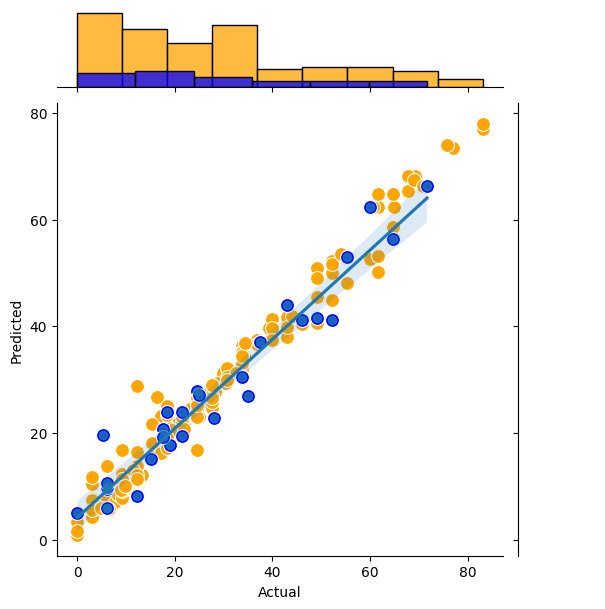

In [ ]:
# Fitting RandomForest Regression with optimized parameters
model_RF2 =  RandomForestRegressor(max_depth = 20, max_features = 'sqrt',
                   min_samples_split = 2, n_estimators = 300, random_state = 0)
model_RF2.fit(X_train, y_train)


# Measure the R2 for training and test set
model_score = model_RF2.score(X_train,y_train)
print("The training R2 is: ", model_RF2.score(X_train, y_train))
print("The test R2 is: ", model_RF2.score(X_test, y_test))


# The mean squared error & Variance
y_predicted = model_RF2.predict(X_test)
y_predicted_train = model_RF2.predict(X_train)

print("MSE: %.2f"% mean_squared_error(y_test, y_predicted))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y_train, y_predicted_train)))


# K-cross validation
accuracies = cross_val_score(estimator = model_RF2, X = X_train, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())

# Plotting the joint plot of  actual v/s predicted
pp_tr = model_RF2.predict(X_train)

g = sns.JointGrid()
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)

g.set_axis_labels("Actual", "Predicted")
sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')

plt.locator_params(tight=None, nbins=5)
plt.show()

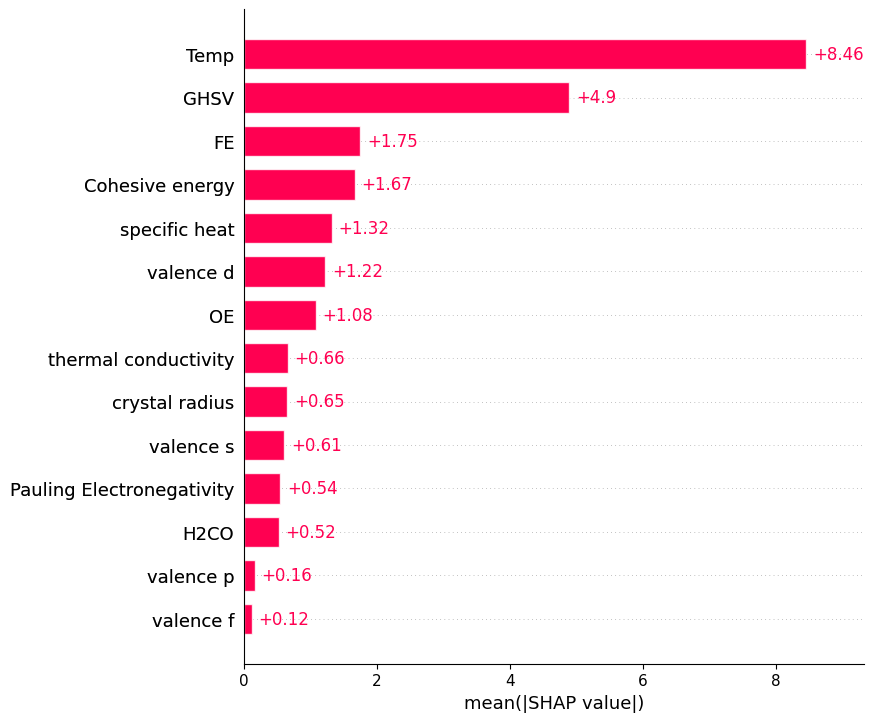

In [ ]:
def plot_SHAP (X, model):
  import shap
  explainer = shap.Explainer(model)
  shap_values = explainer(X)
  shap.plots.bar(shap_values, max_display=15)

plot_SHAP(X_train, model_RF2)

##  2.Gradient Boosting Regressor

In [ ]:
model_GBR1 = GradientBoostingRegressor(random_state = 0)

param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
              }

tuning = GridSearchCV(estimator=model_GBR1,
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

tuning.fit(X_train, y_train)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters:
{'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 100}


The training R2 is: 0.997
The test R2 is: 0.952 
MSE: 18.97
RMSE of test set: 4.36
RMSE of train set: 1.17
The mean accuracy is:  0.834277473648201


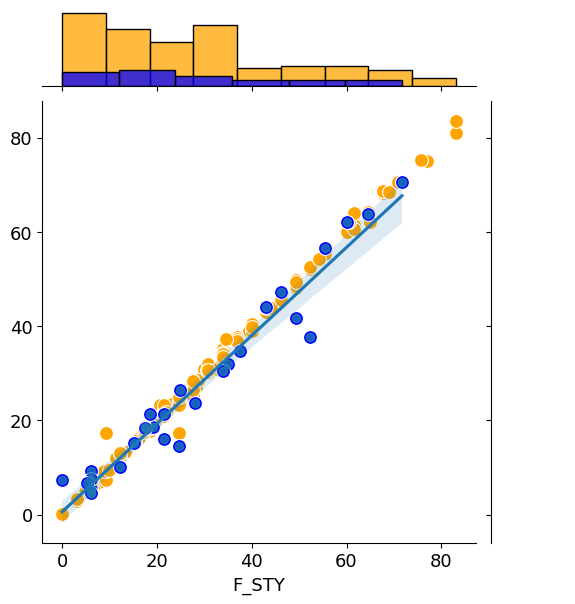

In [ ]:
# Fitting GBDT Regression to training data
model_GBR2 =  GradientBoostingRegressor(learning_rate = 0.2, max_depth = 4,
                      min_samples_leaf = 1, n_estimators = 100, random_state = 0)

model_GBR2.fit(X_train, y_train)

# Measure the R2 for training and test set
model_score = model_GBR2.score(X_train,y_train)
print("The training R2 is: %.3f" % model_GBR2.score(X_train, y_train))
print("The test R2 is: %.3f "% model_GBR2.score(X_test, y_test))

# The mean squared error & Variance
y_predicted = model_GBR2.predict(X_test)
y_predicted_train = model_GBR2.predict(X_train)

print("MSE: %.2f"% mean_squared_error(y_test, y_predicted))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y_train, y_predicted_train)))

# K-cross validation
accuracies = cross_val_score(estimator = model_GBR2, X = X_train, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())



# Plotting the joint plot of  actual v/s predicted
pp_tr = model_GBR2.predict(X_train)

g = sns.JointGrid()
sns.scatterplot(x=y_train, y=pp_tr, s=100, color='orange', ax=g.ax_joint)
sns.scatterplot(x=y_test, y=y_predicted, s=100, color='blue', ax=g.ax_joint)
sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint)

sns.histplot(x=y_train,ax=g.ax_marg_x, color ='orange')
sns.histplot(x=y_test, ax=g.ax_marg_x, color ='blue')

plt.locator_params(tight=None, nbins=5)
plt.show()

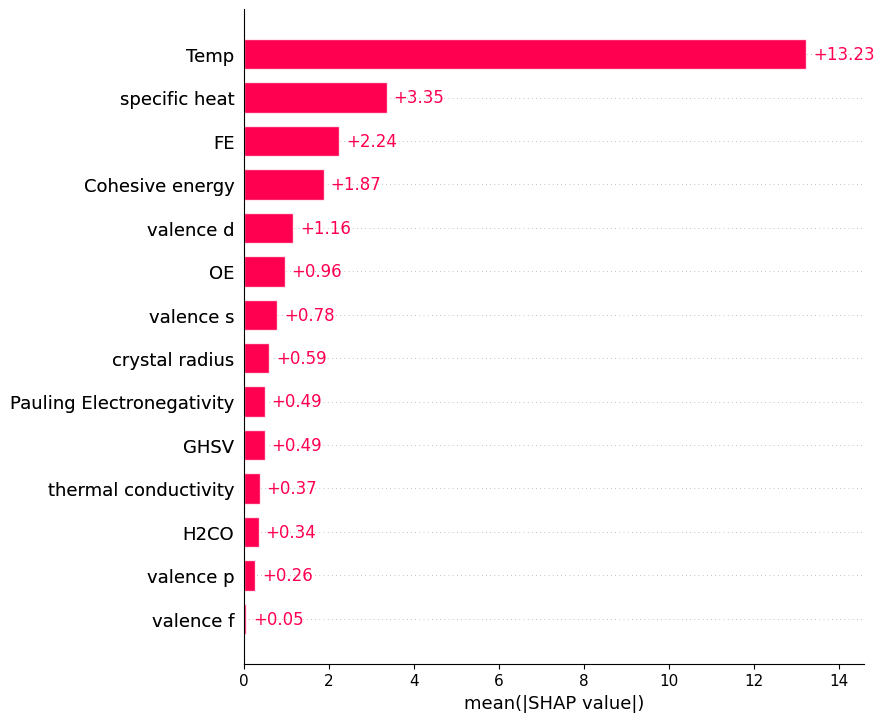

In [ ]:
explainer2 = shap.Explainer(model_GBR2)
shap_values2 = explainer2(X_train)
shap.plots.bar(shap_values2, max_display=15)

# D. Train on full data set -> final paper results

## 1.Random Forest -> reference paper results!!!

In [ ]:
model = RandomForestRegressor(random_state = 0)

param_grid={'n_estimators':np.arange(100,1001,100).tolist(),
                'max_features':["sqrt"],
                'max_depth':[20,40,60,80],
                'min_samples_split':[2,4,6,8,10]}

tuning = GridSearchCV(estimator=model,
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
model_full_RF =  RandomForestRegressor(max_depth = 20,
                                       max_features = 'sqrt',
                                       min_samples_split = 2,
                                       n_estimators = 100,
                                       random_state = 0)
model_full_RF.fit(X, y)

# training set R2
model_score = model_full_RF.score(X,y)
print("training set R2: %.3f"% model_full_RF.score(X, y))

# training set MSE and RMSE
y_predicted_all = model_full_RF.predict(X)
print("training set MSE: %.3f"% mean_squared_error(y, y_predicted_all))
print("training set RMSE: %.3f"% sqrt(mean_squared_error(y, y_predicted_all)))


# k-cross validation
scores = cross_validate(estimator = model_full_RF, X=X, y=y, cv=5, scoring=('r2'), return_train_score=True)
accuracies = cross_val_score(estimator = model_full_RF, X = X, y= y, cv=5)

print("training set cv_score: %.3f"% accuracies.mean())


training set R2: 0.976
training set MSE: 9.825
training set RMSE: 3.135
training set cv_score: 0.556


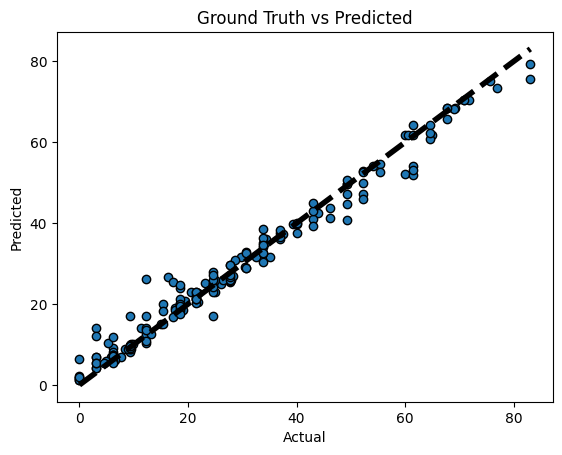

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y, y_predicted_all, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

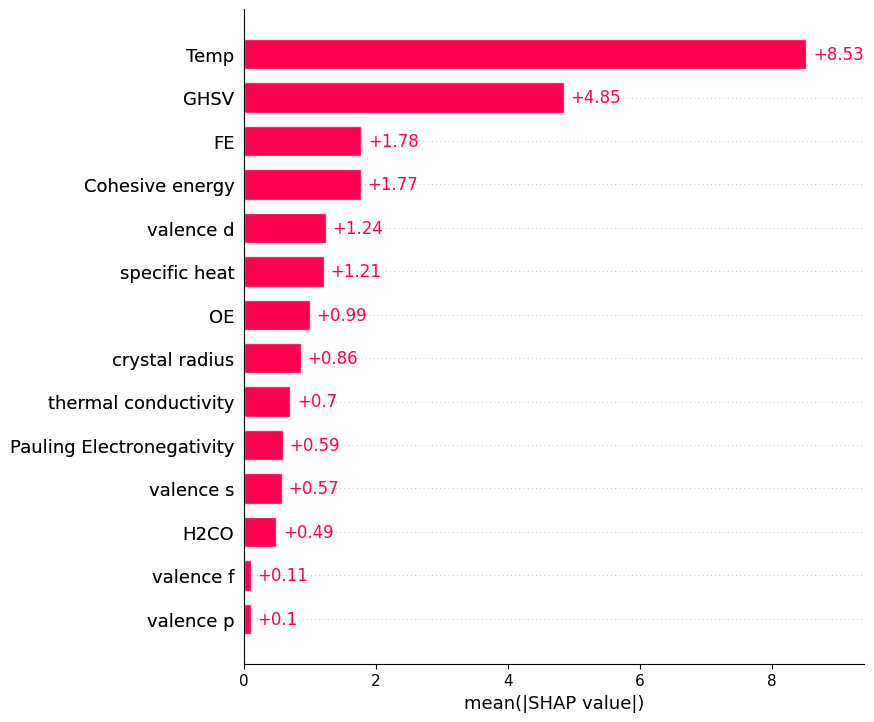

In [ ]:
explainer = shap.Explainer(model_full_RF)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=15)

In [ ]:
feature_names = X.columns

# Compute the average absolute SHAP value for each feature
average_shap = np.mean(np.abs(shap_values.values), axis=0)

# Pair and sort feature names with their average SHAP values
sorted_features = sorted(zip(feature_names, average_shap), key=lambda x: x[1], reverse=True)

# Display sorted pairs
for feature, value in sorted_features:
    print(f"{feature}: {value:.3f}")


Temp: 8.526
GHSV: 4.845
FE: 1.775
Cohesive energy: 1.769
valence d: 1.243
specific heat: 1.213
OE: 0.994
crystal radius: 0.864
thermal conductivity: 0.699
Pauling Electronegativity: 0.588
valence s: 0.569
H2CO: 0.488
valence f: 0.106
valence p: 0.103


The SHAP values from the reference paper by Suvarna et al.
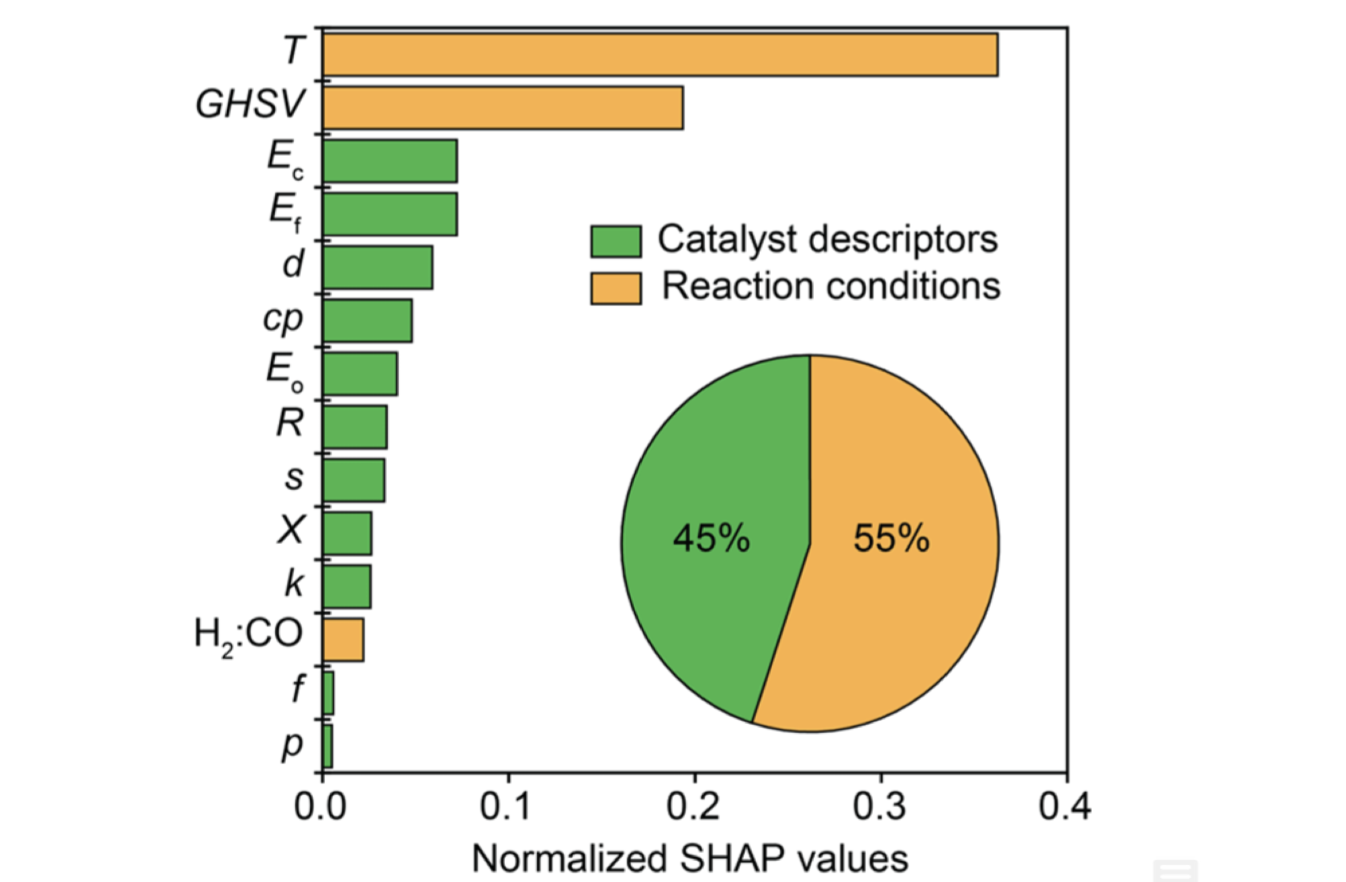

### Calculate confidence interval for the SHAP values

In [ ]:
shap_analyzer = SHAPConfidenceAnalyzer(0.95, X, model_full_RF, n_samples=1000)

df_CI = shap_analyzer.compute_confidence_intervals(random_seed=0)
df_CI

,Feature,Absolute Mean SHAP,Lower Bound,Upper Bound,Interval Length
13,Temp,8.525879,7.963470,9.162542,1.199071
11,GHSV,4.846193,4.653590,5.054406,0.400816
2,FE,1.779340,1.615558,1.950300,0.334742
10,Cohesive energy,1.770436,1.608766,1.932013,0.323248
6,valence d,1.242533,1.108465,1.381252,0.272787
8,specific heat,1.216370,1.096325,1.331684,0.235359
3,OE,0.994254,0.882342,1.108009,0.225667
0,crystal radius,0.865128,0.776403,0.962975,0.186572
9,thermal conductivity,0.699250,0.630757,0.773474,0.142717
1,Pauling Electronegativity,0.588333,0.512719,0.658089,0.145369


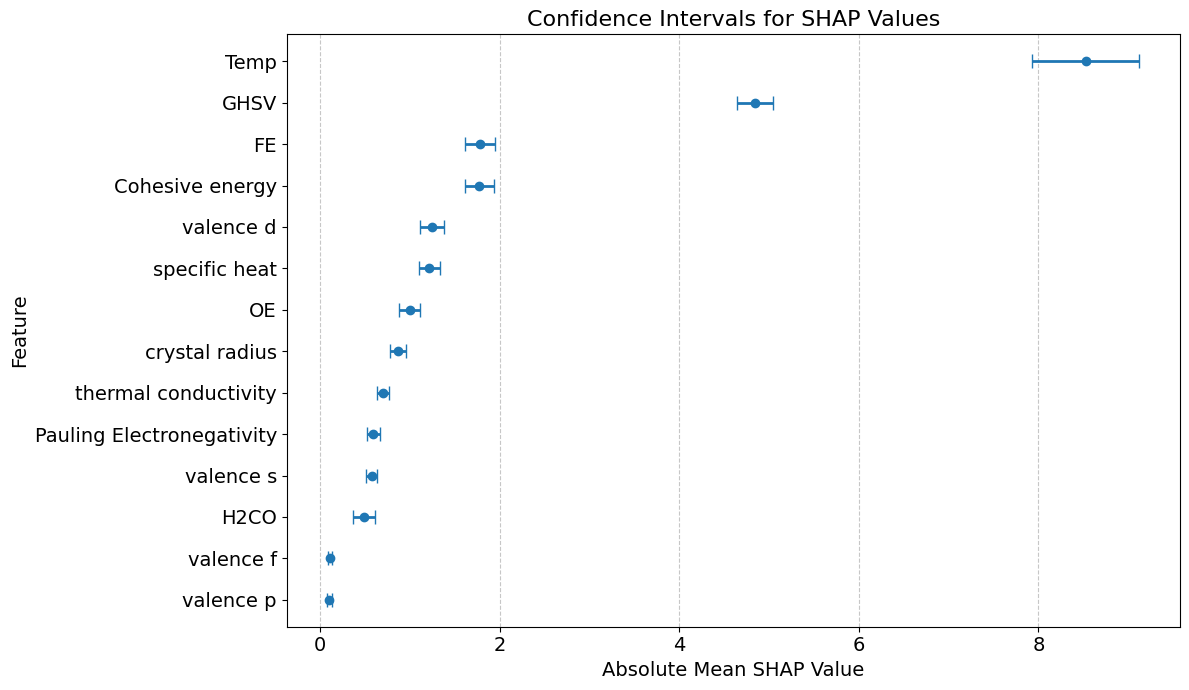

In [ ]:
shap_analyzer.plot_confidence_intervals(df_CI)

## 2.Gradient Boosting Regressor

In [ ]:

model_full = GradientBoostingRegressor(random_state = 0)

param_grid = {'learning_rate':[0.1,0.15,0.2],
              'n_estimators':np.arange(100,1001,100).tolist(),
                 'max_depth':[2,4,6,8],
                 'min_samples_leaf':[1,2],
                 }

tuning = GridSearchCV(estimator=model_full,
                          param_grid = param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters:
{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 100}


In [ ]:
# Fitting Gradient boost regression to entire data

model_full_GBR =  GradientBoostingRegressor(learning_rate = 0.1, max_depth = 6,
                      min_samples_leaf = 2, n_estimators = 100, random_state = 0)
model_full_GBR.fit(X, y)


#Measure the R2 for training and test set
model_score = model_full_GBR.score(X,y)
print("The training R2 is: ", model_full_GBR.score(X, y))
#print("The test R2 is: ", model.score(X, y))

# The mean squared error & Variance
from sklearn.metrics import mean_squared_error
from math import sqrt
y_predicted_all = model_full_GBR.predict(X)
print("MSE: %.2f"% mean_squared_error(y, y_predicted_all))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y, y_predicted_all)))


# K-cross validation
scores = cross_validate(estimator = model_full_GBR, X=X, y=y, cv=5, scoring=('r2'), return_train_score=True)
accuracies = cross_val_score(estimator = model_full_GBR, X = X, y= y, cv=5)
#print("The mean accuracy is: ", accuracies.mean())
# print(scores)
print("The mean accuracy is: ", accuracies.mean())
# accuracies

The training R2 is:  0.9969288421011417
MSE: 1.28
RMSE of train set: 1.13
The mean accuracy is:  0.49629791163137427


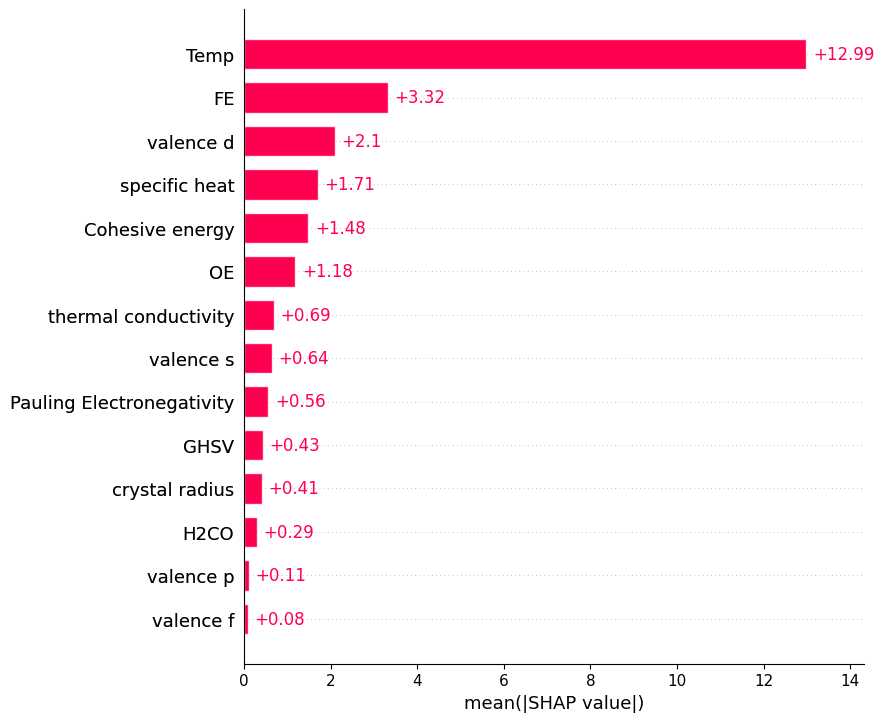

In [ ]:
explainer = shap.Explainer(model_full_GBR)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=15)

### Confidence intervals for the SHAP values

In [ ]:
shap_analyzer1 = SHAPConfidenceAnalyzer(0.95, X, model_full_GBR, n_samples=1000)

df_CI1 = shap_analyzer1.compute_confidence_intervals(random_seed=0)
df_CI1

,Feature,Absolute Mean SHAP,Lower Bound,Upper Bound,Interval Length
13,Temp,12.983732,11.823482,14.128824,2.305342
2,FE,3.329081,2.929893,3.739730,0.809838
6,valence d,2.099986,1.884221,2.337014,0.452793
8,specific heat,1.714502,1.542291,1.908566,0.366275
10,Cohesive energy,1.478277,1.294804,1.689527,0.394724
3,OE,1.185442,1.064818,1.309630,0.244812
9,thermal conductivity,0.690742,0.580282,0.816389,0.236107
4,valence s,0.642794,0.531556,0.769888,0.238332
1,Pauling Electronegativity,0.557272,0.480526,0.647119,0.166594
11,GHSV,0.434407,0.364187,0.508460,0.144273


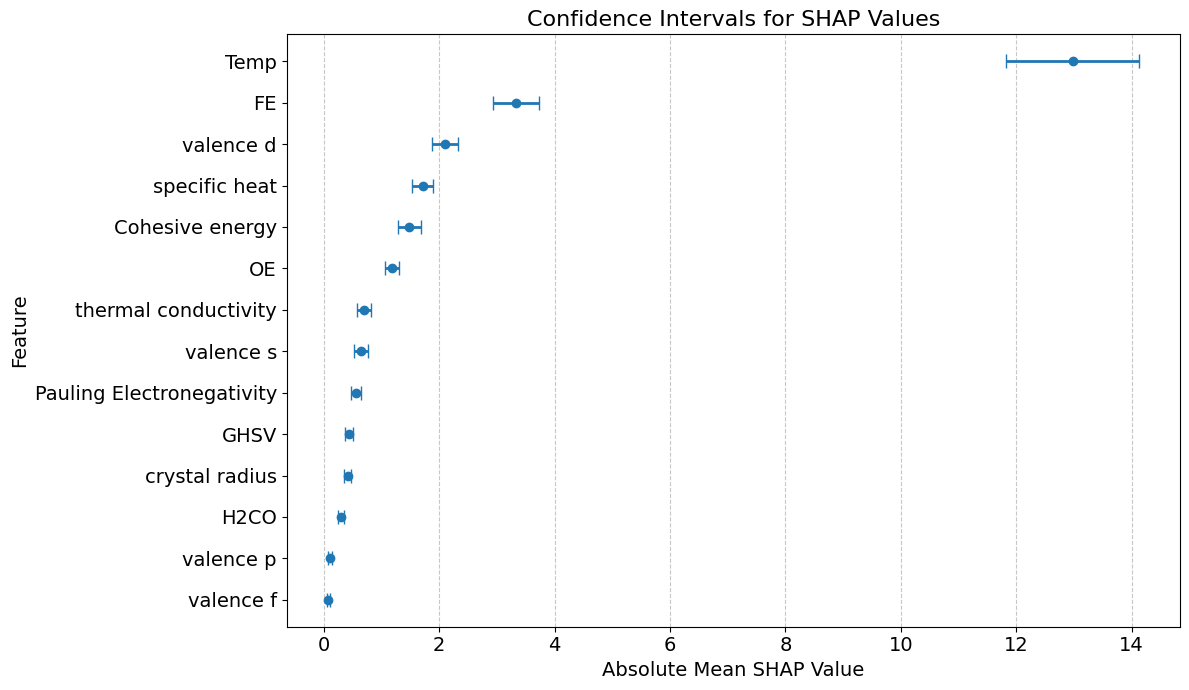

In [ ]:
shap_analyzer1.plot_confidence_intervals(df_CI1)

# E. Explore the effects of changing random seeds

In [ ]:
def random_seed_effect(seeds, model, X_train, y_train, X_test, y_test):
  all_metrics = []

  for seed in seeds:
    model.random_state = seed

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
    cv_scores = cross_val_score(model, X_train, y_train, cv=5).mean()

    metrics = {
        'random_seed': seed,
        'training_R2': train_r2,
        'test_R2': test_r2,
        'training_RMSE': train_rmse,
        'test_RMSE': test_rmse,
        'cv_scores': cv_scores,
    }

    all_metrics.append(metrics)

  df_all_metrics = pd.DataFrame(all_metrics)

  return df_all_metrics

### Random forest trained with full dataset

In [ ]:
# original random seed = 0
# try 100 different random seeds

model = model_full_RF
seeds = np.arange(1, 101)
all_metrics = []

metrics = random_seed_effect(seeds, model, X_train, y_train, X_test, y_test)

In [ ]:
metrics

,random_seed,training_R2,test_R2,training_RMSE,test_RMSE,cv_scores
0,1,0.969469,0.930381,3.591787,5.229509,0.771497
1,2,0.972466,0.931966,3.410912,5.169645,0.767386
2,3,0.967578,0.930190,3.701305,5.236662,0.774758
3,4,0.967578,0.925532,3.701302,5.408554,0.776441
4,5,0.973660,0.929001,3.336143,5.281094,0.763457
...,...,...,...,...,...,...
95,96,0.970064,0.929051,3.556564,5.279235,0.773162
96,97,0.970939,0.919726,3.504238,5.615449,0.789983
97,98,0.968620,0.932365,3.641374,5.154439,0.774130
98,99,0.969544,0.929747,3.587329,5.253280,0.784842


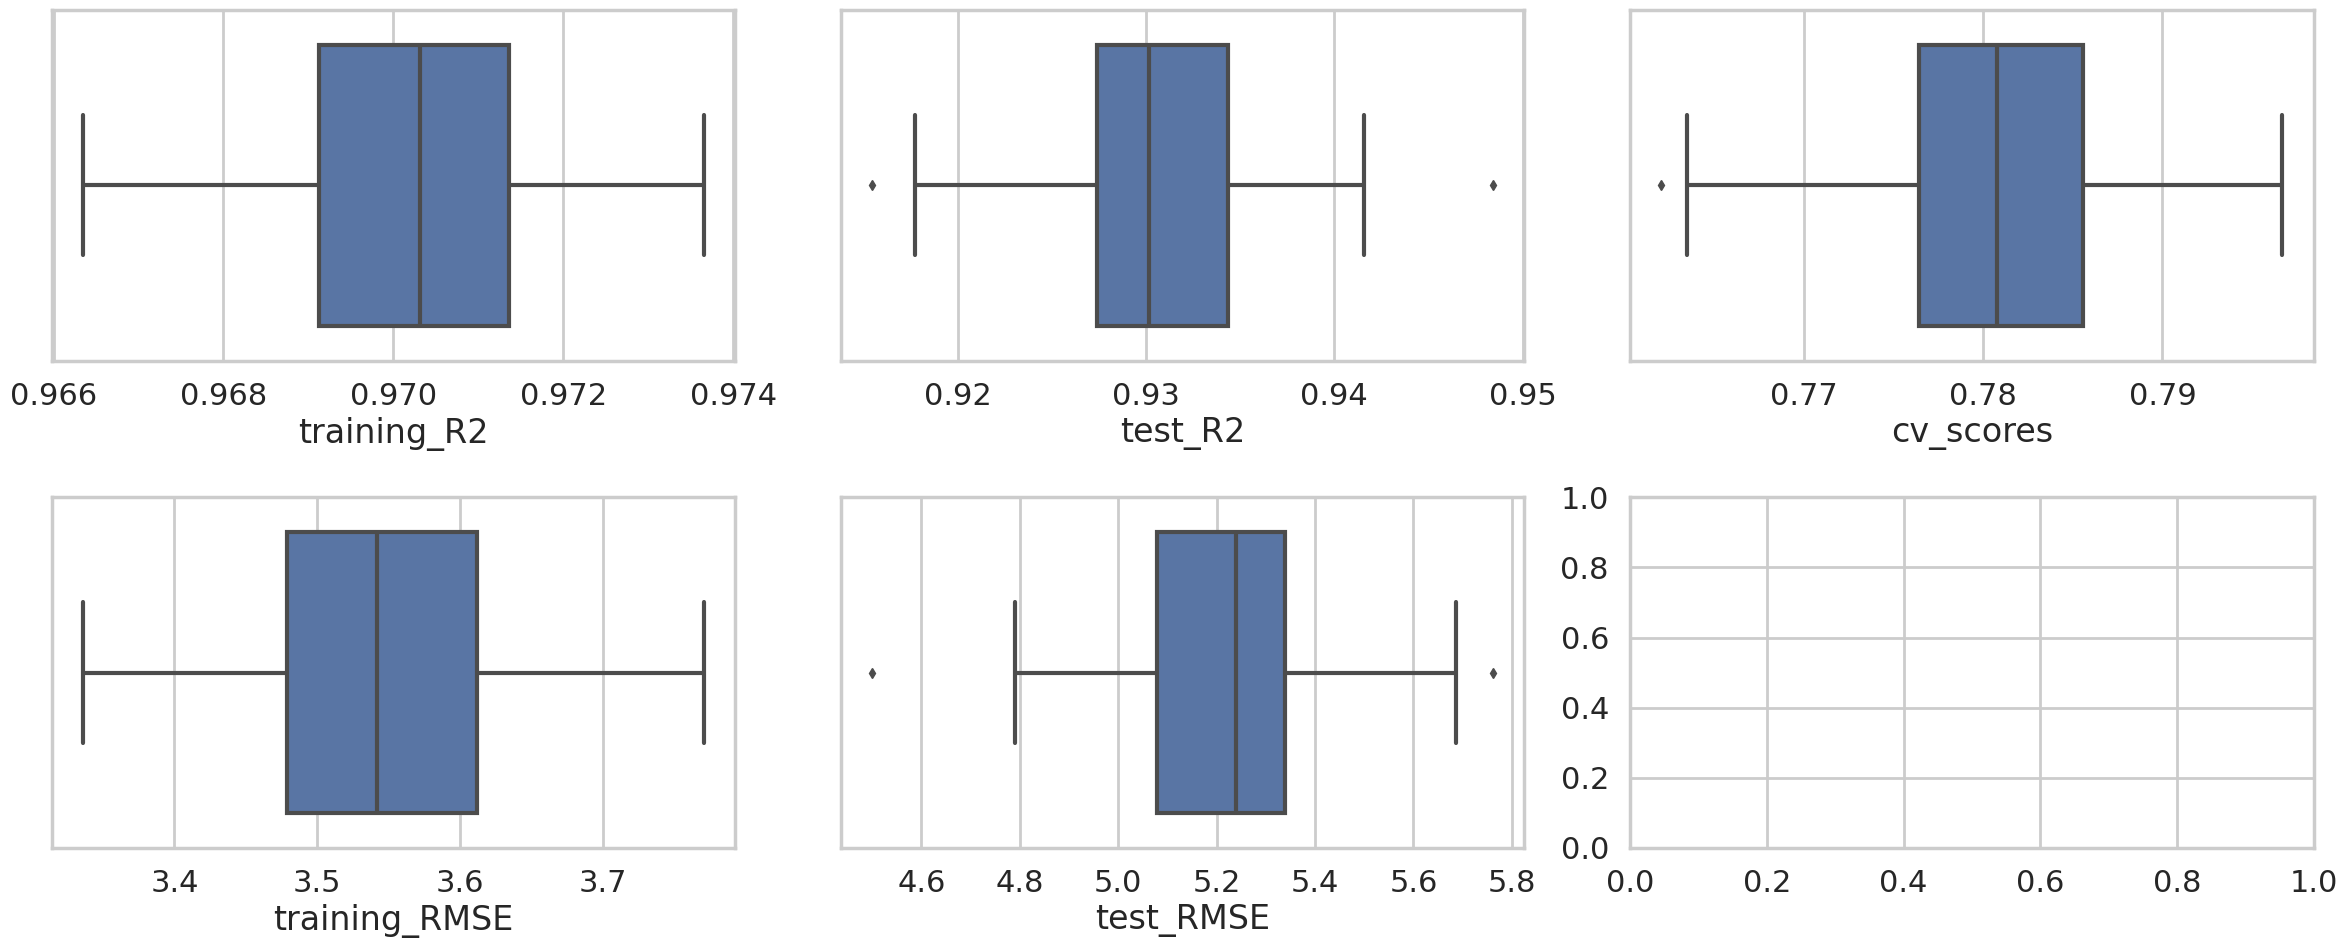

In [ ]:
sns.set(style="whitegrid")
sns.set_context("poster")  # This sets a predefined larger font size context, alternatives are "notebook", "paper", "talk", and "poster"

fig, axes = plt.subplots(2, 3, figsize=(24, 10))

sns.boxplot(ax=axes[0, 0], data=metrics, x='training_R2')

sns.boxplot(ax=axes[0, 1], data=metrics, x='test_R2')

sns.boxplot(ax=axes[0, 2], data=metrics, x='cv_scores')

sns.boxplot(ax=axes[1, 0], data=metrics, x='training_RMSE')

sns.boxplot(ax=axes[1, 1], data=metrics, x='test_RMSE')

plt.tight_layout()
plt.show()


Random seed has little influence on model performance

### Gradient boost trees trained with full dataset

In [ ]:
# original random seed = 0
# try 100 different random seeds

model = model_full_GBR
seeds = np.arange(1, 101)
all_metrics = []

metrics = random_seed_effect(seeds, model, X_train, y_train, X_test, y_test)

In [ ]:
metrics

,random_seed,training_R2,test_R2,training_RMSE,test_RMSE,cv_scores
0,1,0.996965,0.944699,1.132442,4.660828,0.797213
1,2,0.996965,0.942692,1.132442,4.744675,0.797932
2,3,0.996965,0.941661,1.132442,4.787137,0.798929
3,4,0.996965,0.944075,1.132442,4.687040,0.799368
4,5,0.996965,0.944200,1.132442,4.681793,0.797378
...,...,...,...,...,...,...
95,96,0.996965,0.946978,1.132442,4.563789,0.799529
96,97,0.996965,0.944934,1.132442,4.650924,0.797222
97,98,0.996965,0.944080,1.132442,4.686832,0.800976
98,99,0.996965,0.949336,1.132442,4.461149,0.796527


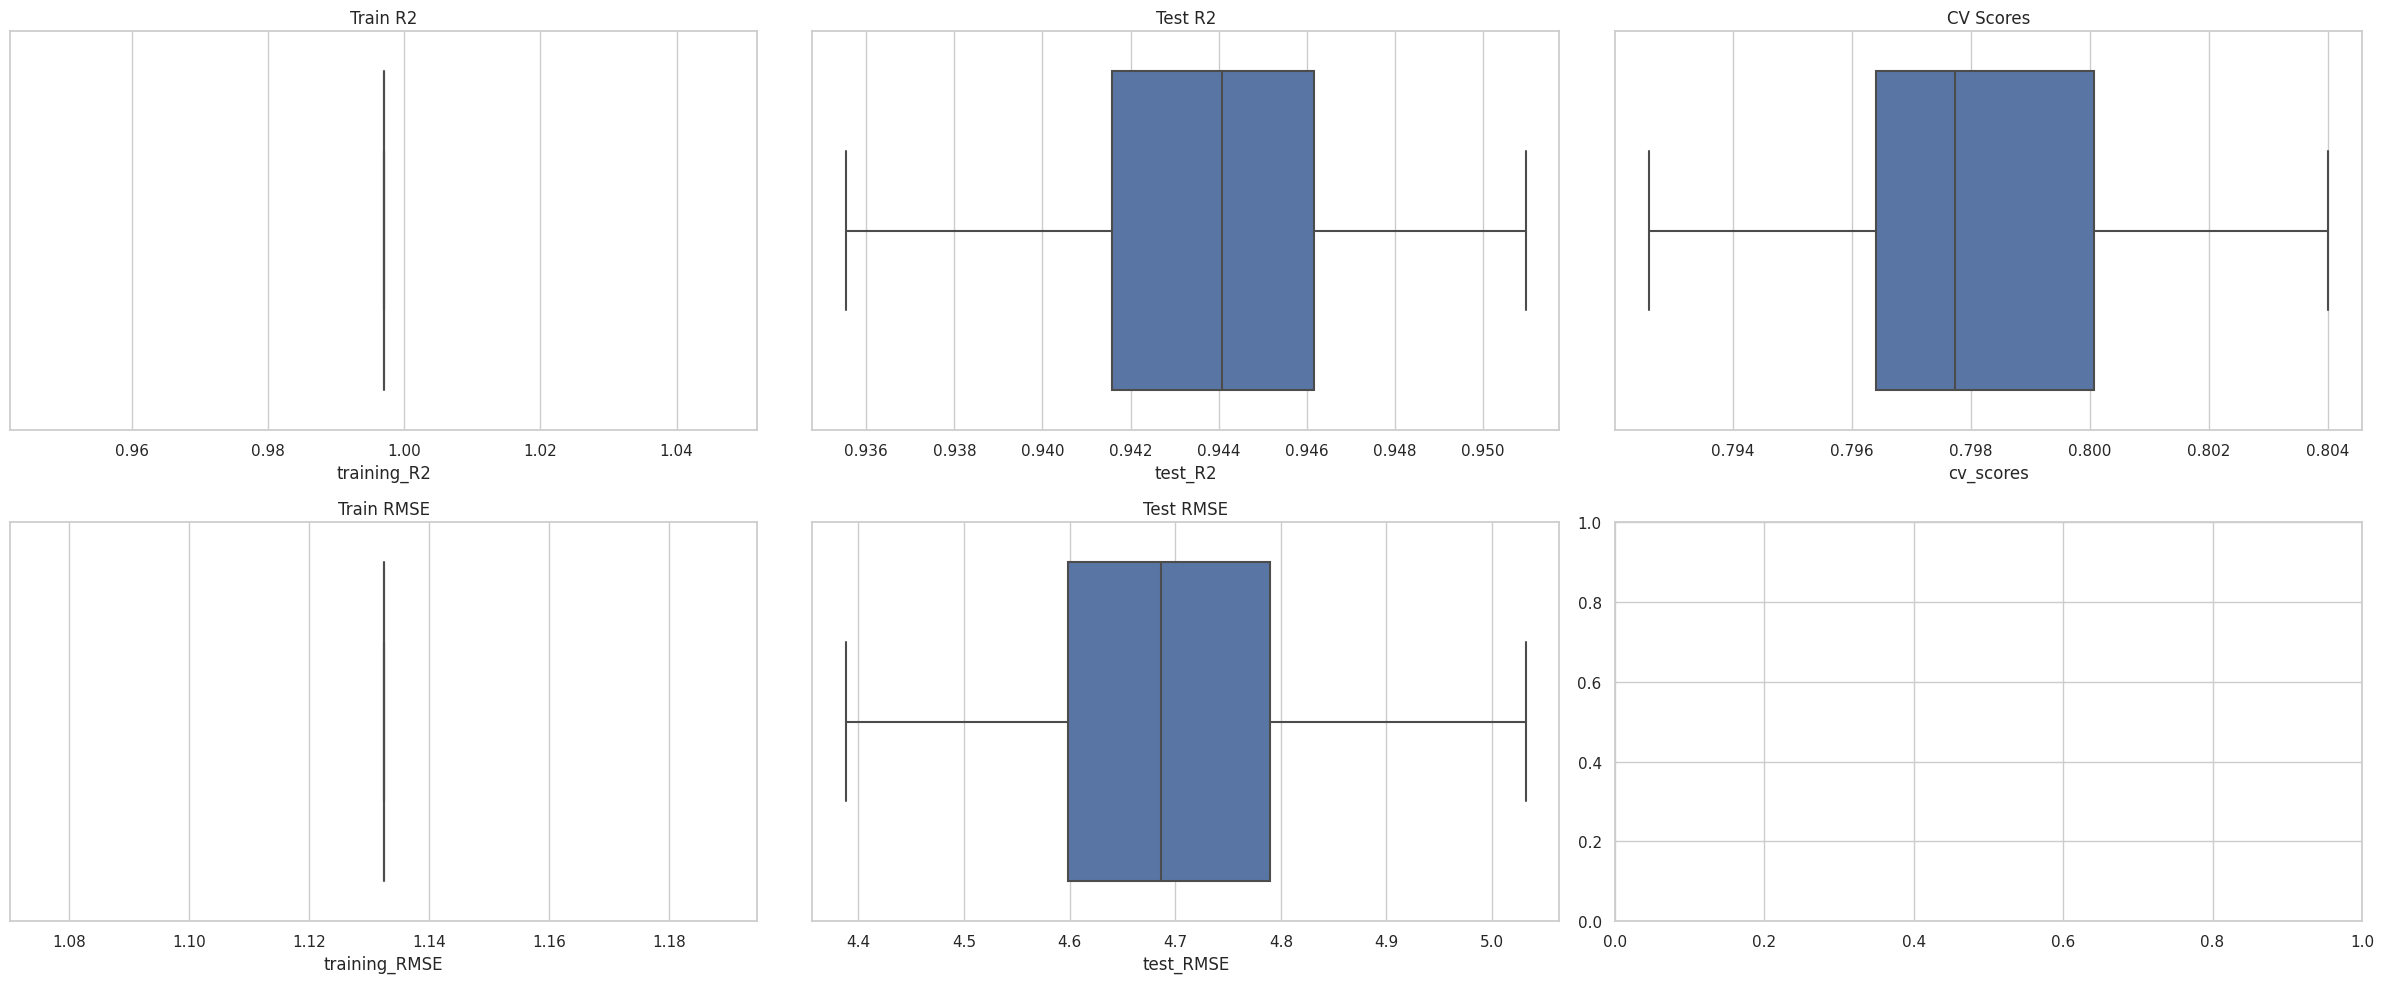

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(24, 10))

sns.boxplot(ax=axes[0, 0], data=metrics, x='training_R2')
axes[0, 0].set_title('Train R2')

sns.boxplot(ax=axes[0, 1], data=metrics, x='test_R2')
axes[0, 1].set_title('Test R2')

sns.boxplot(ax=axes[0, 2], data=metrics, x='cv_scores')
axes[0, 2].set_title('CV Scores')

sns.boxplot(ax=axes[1, 0], data=metrics, x='training_RMSE')
axes[1, 0].set_title('Train RMSE')

sns.boxplot(ax=axes[1, 1], data=metrics, x='test_RMSE')
axes[1, 1].set_title('Test RMSE')

plt.tight_layout()
plt.show()
